# Extract PCA Features from Gene Expression

This notebook applies **Principal Component Analysis (PCA)** to the gene expression data from the aligned pseudo-bulk dataset.

The goal is to:
- Reduce dimensionality while retaining most of the biological signal
- Generate a compact representation (PCs) to be used in downstream modeling

We’ll also:
- Visualize explained variance per PC
- Select the number of PCs based on cumulative variance


In [8]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import polars as pl

# Load your large dataset
aligned = pd.read_parquet("../../data/processed/voom_transformed_data.parquet")

# Extract sanger_ids for tracking
sanger_ids = aligned.index.to_series().rename("SANGER_MODEL_ID").reset_index(drop=True)

# Convert aligned data to numpy for PCA
X = aligned.to_numpy()

# Standardize
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

print("✅ New dataset prepared.")
print(f"Gene matrix shape: {X.shape}")


✅ New dataset prepared.
Gene matrix shape: (1362, 37602)


In [9]:
pca_full = PCA(n_components=100, random_state=42)
X_pca_full = pca_full.fit_transform(X)

explained_var_ratio = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var_ratio)


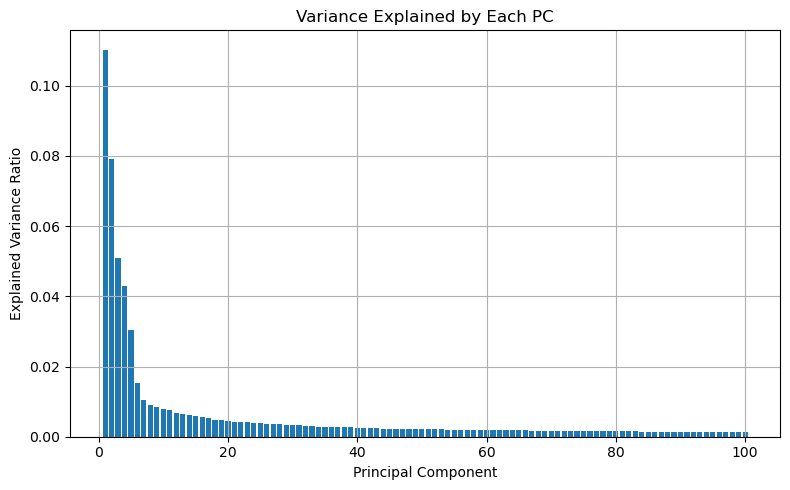

In [10]:
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_var_ratio) + 1), explained_var_ratio)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Variance Explained by Each PC")
plt.grid(True)
plt.tight_layout()
plt.show()


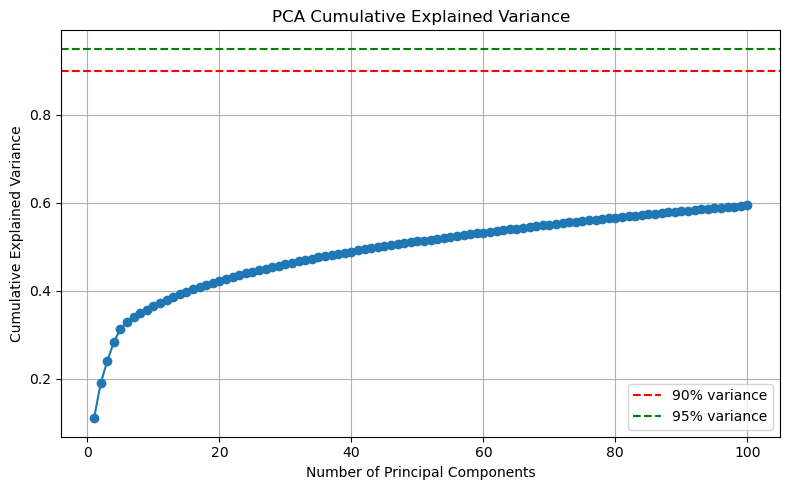

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker="o")
plt.axhline(0.9, linestyle="--", color="red", label="90% variance")
plt.axhline(0.95, linestyle="--", color="green", label="95% variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Cumulative Explained Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
n_90 = np.argmax(cumulative_var >= 0.90) + 1
print(f"✅ Number of PCs needed to explain 90% of variance: {n_90}")


✅ Number of PCs needed to explain 90% of variance: 1


## 3. Apply Final PCA with Selected Number of Components

Based on the analysis above, we now apply PCA using the number of components that captures sufficient variance (e.g., 50 or the `n_90` value).


In [13]:
# Set the number of components to retain (either manually or using n_90)
N_COMPONENTS = 30

# Run final PCA
pca_final = PCA(n_components=N_COMPONENTS, random_state=42)
X_pca = pca_final.fit_transform(X_scaled)

# Create column names for PCs
pca_cols = [f"PC{i+1}" for i in range(N_COMPONENTS)]
pca_df = pd.DataFrame(X_pca, columns=pca_cols)

# Reattach the SANGER_MODEL_ID column you stored earlier
pca_df = pd.concat([sanger_ids, pca_df], axis=1)

# Convert to Polars for saving and consistency
final_pl = pl.from_pandas(pca_df)

print("✅ Final PCA applied.")
print(f"Resulting shape: {final_pl.shape}")
final_pl.head()


✅ Final PCA applied.
Resulting shape: (1362, 31)


SANGER_MODEL_ID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""SIDM00001""",36.680137,-108.91673,56.473691,0.771919,-11.63778,-13.142316,6.079679,-5.963701,18.913293,-6.45981,-12.099019,5.701266,-1.415556,11.265734,21.206923,23.144416,7.201743,4.311111,6.895278,-3.942937,17.938142,-1.859997,6.638627,16.156279,-11.605182,8.449281,-1.381387,2.35192,-6.035632,-4.065383
"""SIDM00002""",-133.36296,-134.214713,-4.774935,26.812084,35.160123,21.054091,14.802906,-14.423738,-21.986601,-1.122292,16.726099,18.589108,13.103303,17.106705,37.970889,0.859251,-10.760801,13.806983,63.061276,1.667925,-16.318921,4.487914,11.436827,-10.600912,10.794464,-1.595011,-7.773263,14.834627,-1.964793,-0.329101
"""SIDM00003""",-167.013738,-135.75486,-15.002974,13.782977,-15.402915,23.097619,-14.083559,48.643579,4.459391,-10.701415,30.2262,0.790024,-11.545111,13.977003,-12.35753,41.148731,-4.522828,-23.261595,2.120974,5.870821,-1.368905,2.351495,14.867236,6.868667,-1.226268,-10.181182,-19.426838,-4.952759,-2.425185,-7.794106
"""SIDM00005""",60.007001,-117.317987,1.873497,15.408201,42.603928,-21.950439,28.109972,0.958338,-24.287058,2.936561,-2.406205,-14.217834,-10.725687,3.055467,-3.652482,14.552643,25.763363,26.333258,-12.261865,18.77829,-19.796545,-2.375235,0.094292,32.32235,-6.721867,-6.239562,-14.265226,-5.260007,10.185986,-0.584674
"""SIDM00006""",-153.725113,-131.039516,-31.551507,33.446173,4.572226,14.449591,13.872287,-3.370174,14.243639,-12.150304,-5.408805,17.707451,10.540031,5.612865,10.56515,5.887379,-4.279674,2.150993,3.380465,24.517977,12.581122,9.585681,11.218822,-9.925002,7.46546,-7.720456,3.263039,-1.319931,-25.993713,10.562543


## 4. Save PCA-Reduced Dataset

We save the PCA features to a new file, ready for model training or visualization.


In [14]:
# 📥 Load GDSC drug response data
gdsc_bulk = pl.read_parquet("../../data/processed/gdsc_final_cleaned.parquet").select([
    pl.col("SANGER_MODEL_ID").cast(pl.Utf8),
    pl.col("DRUG_ID").cast(pl.Int32),
    pl.col("LN_IC50").cast(pl.Float32)
])

# 🔗 Merge PCA-transformed cell line profiles with GDSC drug response
merged = gdsc_bulk.join(final_pl, on="SANGER_MODEL_ID", how="left")

# ✅ Confirm merge
print("✅ Merged GDSC with PCA-transformed expression.")
print(f"Final shape: {merged.shape}")
print(merged.head())

# 💾 Save the merged dataset
merged.write_parquet("../../data/processed/bulk_voom_pca.parquet")
print("📁 Saved merged dataset to 'bulk_with_pca.parquet'")


✅ Merged GDSC with PCA-transformed expression.
Final shape: (571985, 33)
shape: (5, 33)
┌────────────┬─────────┬──────────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ SANGER_MOD ┆ DRUG_ID ┆ LN_IC50  ┆ PC1        ┆ … ┆ PC27      ┆ PC28      ┆ PC29      ┆ PC30      │
│ EL_ID      ┆ ---     ┆ ---      ┆ ---        ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ ---        ┆ i32     ┆ f32      ┆ f64        ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
│ str        ┆         ┆          ┆            ┆   ┆           ┆           ┆           ┆           │
╞════════════╪═════════╪══════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ SIDM00263  ┆ 1       ┆ 3.966813 ┆ -143.77893 ┆ … ┆ -5.765744 ┆ 0.822856  ┆ 12.114901 ┆ -6.122686 │
│            ┆         ┆          ┆ 5          ┆   ┆           ┆           ┆           ┆           │
│ SIDM00269  ┆ 1       ┆ 2.69209  ┆ -111.73255 ┆ … ┆ -5.694266 ┆ 10.885021 ┆ 11.310926 ┆ -9.606058 │
│ S